In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import models
from torchsummary import summary

In [3]:
! pip install torchsummary

In [4]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_image(image_tensor):
    """
    Plot the whole image represented by the given tensor.

    Arguments:
        image_tensor (torch.Tensor): Tensor representing the image.
    """
    # Convert tensor to NumPy array
    image_array = image_tensor.numpy()

    # Plot the image
    plt.imshow(image_array, cmap='gray')
    plt.axis('off')
    plt.show()

import matplotlib.pyplot as plt

def plot_image_pair(image_pair):
    """
    Plot image pair and their label.

    Arguments:
        image_pair (tuple): Tuple containing two image tensors and their label.
    """
    # Extract images and label from the tuple
    img0_tensor, img1_tensor, label = image_pair

    # Convert tensors to NumPy arrays and remove singleton channel dimension
    img0_array = img0_tensor.squeeze().numpy()
    img1_array = img1_tensor.squeeze().numpy()

    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img0_array, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Image 0')

    axes[1].imshow(img1_array, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Image 1')

    # Convert label to string before using it in the title
    plt.suptitle(f'Label: {str(label)}')
    plt.show()


In [5]:
def show_plot(counter, train_loss_history, val_loss_history):
    """
    Display a plot of the training and validation loss over iterations.

    Args:
        counter (list): List of iteration numbers.
        train_loss_history (list): List of training loss values.
        val_loss_history (list): List of validation loss values.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(counter, train_loss_history, label='Train Loss')
    plt.plot(counter, val_loss_history, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [71]:
def plot_images(image_pair, similarity_score):
    """
    Plot image pair and their similarity score.

    Arguments:
        image_pair (tuple): Tuple containing two image tensors.
        similarity_score (float): Similarity score of the image pair.
    """
    # Extract images from the tuple
    img0, img1 = image_pair

    # Convert tensors to NumPy arrays
    img0_array = img0.squeeze().cpu().numpy()
    img1_array = img1.squeeze().cpu().numpy()

    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img0_array, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Image 0')

    axes[1].imshow(img1_array, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Image 1')

    plt.suptitle(f'Similarity Score: {similarity_score:.2f}')
    plt.show()

In [6]:

class SiameseNetworkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and subfolders.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]

        # Create a list to hold pairs of images
        self.image_pairs = []

        # Iterate over each class folder
        for class_label in self.classes:
            class_folder = os.path.join(self.root_dir, class_label)  # Path to class folder
            subfolders = os.listdir(class_folder)

            # Iterate over each subfolder within the class folder
            for subfolder in subfolders:
                subfolder_path = os.path.join(class_folder, subfolder)

                # Get all pairs of images in the subfolder
                image_names = os.listdir(subfolder_path)
                pair_images = [(os.path.join(subfolder_path, image_names[i]), os.path.join(subfolder_path, image_names[i+1])) for i in range(0, len(image_names), 2)]

                # Add pairs of images along with their class label to the list
                self.image_pairs.extend([(img0, img1, int(class_label)) for img0, img1 in pair_images])

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img0_path, img1_path, class_label = self.image_pairs[idx]

        # Load images
        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)

        # Apply transformations
        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, class_label


In [7]:

root_dir = '/content/drive/MyDrive/Dataset'

classes = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]

        # Create a list to hold pairs of images
image_pairs = []

        # Iterate over each class folder
for class_label in classes:
    class_folder = os.path.join(root_dir, class_label)  # Path to class folder
    subfolders = os.listdir(class_folder)
    i = 0
            # Iterate over each subfolder within the class folder
    for subfolder in subfolders:
        if i < 1:
            subfolder_path = os.path.join(class_folder, subfolder)

                # Get all pairs of images in the subfolder
            image_names = os.listdir(subfolder_path)
            print("1")
            print(image_names,end="")
            pair_images = [(os.path.join(subfolder_path, image_names[i]), os.path.join(subfolder_path, image_names[i+1])) for i in range(0, len(image_names), 2)]
            print("2")
            print(pair_images,end="")

                # Add pairs of images along with their class label to the list
            image_pairs.extend([(img0, img1, int(class_label)) for img0, img1 in pair_images])
            i+=1


1
['child.bmp', 'father.bmp']2
[('/content/drive/MyDrive/Dataset/0/Fingerprint Family (28)/child.bmp', '/content/drive/MyDrive/Dataset/0/Fingerprint Family (28)/father.bmp')]1
['2-0.bmp', '2-1.bmp']2
[('/content/drive/MyDrive/Dataset/1/2/2-0.bmp', '/content/drive/MyDrive/Dataset/1/2/2-1.bmp')]

In [8]:
transformation = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images to a consistent size
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor()  # Convert images to PyTorch tensors
])
root = '/content/drive/MyDrive/Dataset'
# Initialize the ImageFolderDataset
folder_dataset = ImageFolder(root='/content/drive/MyDrive/Dataset')

# Initialize the SiameseNetworkDataset
siamese_dataset = SiameseNetworkDataset(root_dir='/content/drive/MyDrive/Dataset', transform=transformation)

In [9]:
# following transformation has been applied
siamese_dataset.transform

Compose(
    Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=1)
    ToTensor()
)

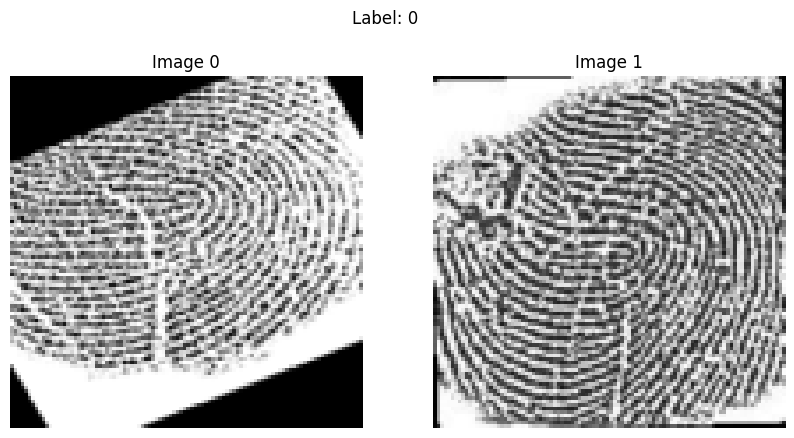

In [10]:
plot_image_pair(siamese_dataset.__getitem__(34))

In [11]:
class_to_idx = folder_dataset.class_to_idx

In [12]:
print(class_to_idx)

{'0': 0, '1': 1}


In [13]:
image_list = folder_dataset.imgs

In [14]:
image = Image.open(image_list[200][0])
print(image)

<PIL.BmpImagePlugin.BmpImageFile image mode=L size=154x192 at 0x7F5C2558ACE0>


In [15]:
image_list = folder_dataset.imgs

In [16]:
siamese_dataset.transform

Compose(
    Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=1)
    ToTensor()
)

In [29]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=9,stride=1,padding = 4,padding_mode = 'zeros'),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2,padding_mode = 'zeros'),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(128,2))

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [30]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [31]:
val_size = int(0.4 * len(siamese_dataset))
test_size = int(0.1 * len(siamese_dataset))
train_size = len(siamese_dataset) - val_size - test_size
print(test_size)
print(val_size)
print(train_size)

27
108
136


In [32]:
indices = list(range(len(siamese_dataset)))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

In [33]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [34]:
batch_size = 32

In [35]:
train_loader = DataLoader(siamese_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(siamese_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(siamese_dataset, batch_size=batch_size, sampler=test_sampler)


In [36]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00005 )

In [37]:
counter = []
train_loss_history = []
val_loss_history = []
iteration_number = 0

def run_epoch(dataloader, train=True):
    """
    Run one epoch of training or validation.

    Args:
        dataloader (DataLoader): DataLoader for the dataset.
        train (bool): Flag indicating whether to perform training or validation.
    """
    global iteration_number
    global counter
    global train_loss_history
    global val_loss_history

    # Set the model to training mode if training is True
    if train:
        net.train()
    else:
        net.eval()

    # Initialize loss for the epoch
    epoch_loss = 0.0

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(dataloader):
        # Send the images and labels to CUDA if available
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients if training
        if train:
            optimizer.zero_grad()

        # Pass the images through the network and obtain outputs
        output1, output2 = net(img0, img1)

        # Calculate the loss
        loss = criterion(output1, output2, label)

        # Perform backpropagation and optimization if training
        if train:
            loss.backward()
            optimizer.step()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

        # Every 10 batches, print the loss and update counters
        if i % 10 == 0:
            print(f"Iteration {iteration_number}: {'Training' if train else 'Validation'} Loss: {loss.item()}")
            counter.append(iteration_number)
            if train:
                train_loss_history.append(loss.item())
            else:
                val_loss_history.append(loss.item())
            iteration_number += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(dataloader)

    return avg_loss



In [42]:
num_epochs = 2

In [43]:
# Iterate through epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    train_loss = run_epoch(train_loader, train=True)

    # Validation phase
    with torch.no_grad():  # Disable gradient calculation during validation
        val_loss = run_epoch(val_loader, train=False)

    # Print epoch-wise loss
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss}, Validation Loss: {val_loss}")

# Print final results
print("Final Results:")
print(f"Train Loss: {train_loss_history[-1]}")
print(f"Validation Loss: {val_loss_history[-1]}")


Epoch 1/2
Iteration 11: Training Loss: 0.14111082255840302
Iteration 12: Validation Loss: 0.45485183596611023
Epoch 1/2: Train Loss: 0.2028350755572319, Validation Loss: 0.47164589166641235
Epoch 2/2
Iteration 13: Training Loss: 0.107393279671669
Iteration 14: Validation Loss: 0.48397645354270935
Epoch 2/2: Train Loss: 0.09409428462386131, Validation Loss: 0.4797678217291832
Final Results:
Train Loss: 0.107393279671669
Validation Loss: 0.48397645354270935


In [44]:
test_loss = run_epoch(test_loader,train=False)
print(f'Average Test Loss: {test_loss:.4f}')

Iteration 15: Validation Loss: 0.48429539799690247
Average Test Loss: 0.4843


In [45]:
torch.save(net,'model.pth')

In [46]:
torch.save(net.state_dict(),'model_state.pth')

In [54]:
summary(net, input_size=[(1, 100, 100), (1, 100, 100)])  # Assuming input images are 100x100 RGB images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 100, 100]           7,872
              ReLU-2         [-1, 96, 100, 100]               0
 LocalResponseNorm-3         [-1, 96, 100, 100]               0
         MaxPool2d-4           [-1, 96, 49, 49]               0
            Conv2d-5          [-1, 256, 49, 49]         614,656
              ReLU-6          [-1, 256, 49, 49]               0
 LocalResponseNorm-7          [-1, 256, 49, 49]               0
         MaxPool2d-8          [-1, 256, 24, 24]               0
         Dropout2d-9          [-1, 256, 24, 24]               0
           Conv2d-10          [-1, 384, 24, 24]         885,120
             ReLU-11          [-1, 384, 24, 24]               0
           Conv2d-12          [-1, 256, 24, 24]         884,992
             ReLU-13          [-1, 256, 24, 24]               0
        MaxPool2d-14          [-1, 256,